In [12]:
import picos
from ncpol2sdpa import *
import cvxopt
import numpy as np
import matplotlib.pyplot as plt


/home/jonas/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [15]:
%matplotlib inline

### Simple SOS problem (vars=2,deg=4), unique minimizer (convex)

Example 5.1 in Lassere, this polynom has one global optimum at $(-.24281483,-.24281483)$ with optimal value $f^*=2.507365$

In [60]:
n_vars=2
level=2# in the unconstrained case choose level=deg(f)/2 always
x = generate_variables('x', n_vars)
obj = 3+2*x[0]+2*x[1] + 2*x[0]*x[1]+3*x[0]**2+3*x[1]**2+x[0]**4+x[1]**4

Generate and solve SDP relaxation. We expect this to work from Hilberts results.

In [61]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(level, objective=obj)
sdp.solve()
print('optimal values: ',sdp.primal, sdp.dual, sdp.status)

optimal values:  2.5073653440899433 2.5073653440899433 optimal


Let's see if the Moment matrix M has rank 1, in this case $M(y^*)=v(x^*)v(x^*)^\intercal$ and we can "read the solution off"

In [128]:
Q=np.matrix(sdp.y_mat[0]) # SOS decomp matrix p=vQv^t
M=np.matrix(sdp.x_mat[0]) # Matrix of Moments
print('rank(M)= ', np.linalg.matrix_rank(M))
print('rank(Q)= ', np.linalg.matrix_rank(Q))

rank(M)=  6
rank(Q)=  6


looks like it's not rank 1. Let's compare $M(y^*)$ and $v(x^*)v(x^*)^\intercal$ 

In [115]:
v=np.array([1,-0.24281483,-0.24281483,0.24281483**2,0.24281483**2,0.24281483**2])
V=np.outer(v,v)
print("rank of vv^T= ", np.linalg.matrix_rank(V))
print("||M-vv^T||= ",np.linalg.norm(V-M))


rank of vv^T=  1
||M-vv^T||=  1.91026802858e-08


looks like they're the same, let's take a closer look at the eigenspectrum of M

In [146]:
np.greater(np.linalg.eigvals(M),0.0000001).sum()

1

We can thus conclude that M is indeed rank 1, which means that the sequence of moments $y^*$ has only *one* representing measure $\mu$. Thus, we can "read off" the solution as M[0,1]=E(x[0])=sdp[x[0]] and M[0,2]=E(x[1])=sdp[x[1]] 

In [149]:
print('optimal point: ',M[0,1],M[0,2])

optimal point:  -0.242814831154 -0.242814831154


The problem is convex and symmetric. Thus, we can check optimality by evaluating the gradient in one dimension!

In [152]:
x_0=sdp[x[0]] 
x_1=sdp[x[1]]
grad= 4*x_0**3+6*x_0+2*x_1+2
print("gradient norm at optimum= ",grad)
assert abs(grad)<=0.01, "gradient not zero"
print("objective value at optimum= ",3+2*x_0+2*x_1 + 2*x_0*x_1+3*x_0**2+3*x_1**2+x_0**4+x_1**4)

gradient norm at optimum=  0.000216831233481
objective value at optimum=  2.50736535053


Finally, we can  get an SOS decomposition

In [31]:
sdp.get_sos_decomposition()

[1.00000001990131*x0**4 + 5.9499644969008e-16*x0**3*x1 + 3.68057343991411e-16*x0**3 + 1.990131036438e-8*x0**2*x1**2 - 1.18254036749394e-15*x0**2*x1 + 3.00000001990131*x0**2 - 4.06448990536292e-16*x0*x1**3 - 7.52328952586128e-16*x0*x1**2 + 2.0*x0*x1 + 2.0*x0 + 1.00000001990131*x1**4 + 6.27460032239037e-17*x1**3 + 3.00000001990131*x1**2 + 2.0*x1 + 0.492634667830602]

$x_0⁴+3x_0²+2x_0x_1+2*x_0+x_1⁴+3x_1²+2*x_1+0.1245$ 

That's just input - optimal value... I would have expected something like

$(x_1+1)²+(x_0+1)²+(x_0+x_1+1)²$

### Simple SOS problem II (vars=1,deg=4), multiple minimizers

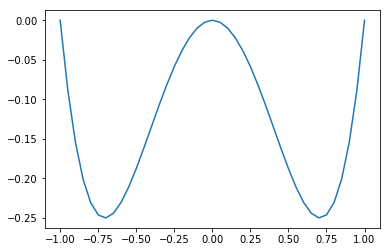

In [23]:
t = np.arange(-1.0, 1.05, 0.05)
plt.plot(t, t**4-t**2)

This polynom has *two* global optima at $1/\sqrt{2}$ and $-1/\sqrt{2}$ with optimal value $f^*=-1/4$

In [6]:
n_vars=1
level= # in the unconstrained case choose level=deg(f)/2 always
x = generate_variables('x', n_vars)
obj = x[0]**4-x[0]**2

sdp = SdpRelaxation(x)
sdp.get_relaxation(level, objective=obj)
sdp.solve()
print('optimal values: ',sdp.primal, sdp.dual, sdp.status)

optimal values:  -0.24999999736598746 -0.24999999736598746 optimal


In [10]:
M=np.matrix(sdp.x_mat[0]) # Matrix of Moments
print('rank(M)= ', np.linalg.matrix_rank(M))


rank(M)=  3


again the rank computation is not accurate, since M has only two significant EVs

In [18]:
np.greater(np.linalg.eigvals(M),0.00000001).sum()

2

rank(M(y*))=2 which suggests the existence of two global minimizers. Let's see what happens if we mistake y_1 for x*

In [26]:
f_y=sdp[x[0]]**4-sdp[x[0]]**2
print (f_y)
assert abs(-1/4-f_y) <0.1, "y_1 does not yield optimal value!"

-2.06897076795e-31


AssertionError: y_1 does not yield optimal value!

As a result, we need to apply Algo 4.2 of the Lasserre Book to obtain $x^*_1$ and $x^*_2$. Unfortunately, the *ncpol2sdpa* seems not to provide this...

### Simple SOS problem III (vars=1,deg=4), unique global minimizer but non-convex

In [ ]:
plt.plot(t, t**4-t**2)

the global minmizers lies at $x^*=-0.73089$ with optimal value $-0.32192$, yet another local minimizer lies at $0.6806$

In [10]:
n_vars=1
level=2 # in the unconstrained case choose level=deg(f)/2 always
x = generate_variables('x', n_vars)
obj = x[0]**4-x[0]**2+1/10*x[0]

sdp = SdpRelaxation(x)
sdp.get_relaxation(level, objective=obj)
sdp.solve()
print('optimal values: ',sdp.primal, sdp.dual, sdp.status)

M=np.matrix(sdp.x_mat[0]) # Matrix of Moments
print('rank(M)= ',np.greater(np.linalg.eigvals(M),0.000001).sum())

f_y=sdp[x[0]]**4-sdp[x[0]]**2+1/10*sdp[x[0]]
print (f_y)
assert abs(-0.32192-f_y) <0.1, "y_1 does not yield optimal value!"



optimal values:  -0.3219193099369817 -0.3219193099369817 optimal
rank(M)=  1
-0.321919310405


again, the global minimizer can be obtained directly from $y^*_1$

### Motzkin (vars=2, deg=6)

In [153]:
n_vars=2
level=3 #half the degree of m(x,y)
x = generate_variables('x', n_vars)
obj = x[0]**2*x[1]**4 +  x[0]**4*x[1]**2 + 1 -3*x[0]**2*x[1]**2

m(x,y) is not SOS so we expect the approach to fail

In [154]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(level, objective=obj)
sdp.solve()
print('optimal values: ',sdp.primal, sdp.dual, sdp.status)
print('optimal point: ',sdp[x[0]]) #that's somehow not correct???

SolverError: Solver 'CVXOPT' failed. Try another solver.